In [ ]:
#Code build up: Joseph Jayakody, Zhang Xiaomeng
#INFH 5000 - face detection and emotion extraction
#Using MTCNN library for face detection 
#fer 2013 open dataset is used as the train model for detecting emotions

!pip install mtcnn

     |████████████████████████████████| 2.3 MB 4.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from matplotlib import pyplot
from PIL import Image 
from numpy import savez_compressed
from numpy import asarray
from os import listdir
from mtcnn.mtcnn import MTCNN

def extract_face(filename, required_size=(160, 160)):
  
  img1 = Image.open(filename)            
  img1 = img1.convert('RGB')         
  pixels = asarray(img1)              
  detector = MTCNN()                 
  f = detector.detect_faces(pixels)
  x1,y1,w,h = f[0]['box']             
  x1, y1 = abs(x1), abs(y1)
  x2 = abs(x1+w)
  y2 = abs(y1+h)
  store_face = pixels[y1:y2,x1:x2]
  plt.imshow(store_face)
  image1 = Image.fromarray(store_face,'RGB')   
  image1 = image1.resize((160,160))             
  face_array = asarray(image1)                  
  return face_array

#We can use extract_face function to extract faces as needed in the next section that can be 
#provided as input to the FaceNet model.

#FaceNet model will be used to create a face embedding for each detected face



1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


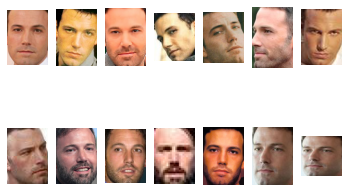

In [ ]:
folder = '/content/drive/MyDrive/Emotion Detection/5-celebrity-faces-dataset/train/ben_afflek/'
i = 1
# enumerate files
for filename in listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face(path)
	print(i, face.shape)
	# plot
	pyplot.subplot(2, 7, i)
	pyplot.axis('off')
	pyplot.imshow(face)
	i += 1
pyplot.show()



In [ ]:
#function below will load all of the faces into a list for a given directory, e.g. ‘5-celebrity-faces-dataset/train/ben_afflek/‘
#We can call the load_faces() function for each subdirectory in the ‘train‘ or ‘val‘ folders. 
#Each face has one label, the name of the celebrity

def load_faces(directory):
  face = []
  i=1
  for filename in listdir(directory):
    path = directory + filename
    faces = extract_face(path)
    face.append(faces)
  return face

In [ ]:
#function below takes a directory name such as ‘5-celebrity-faces-dataset/train/‘ and 
#detects faces for each subdirectory (celebrity), assigning labels to each detected face.

def load_dataset(directory):
  x, y = [],[]
  i=1
  for subdir in listdir(directory):
    path = directory + subdir + '/'
    faces = load_faces(path)
    labels = [subdir for _ in range(len(faces))]
    print("%d There are %d images in the class %s:"%(i,len(faces),subdir))
    x.extend(faces)
    y.extend(labels)
    i=i+1
  return asarray(x),asarray(y)  




1 There are 14 images in the class ben_afflek:
2 There are 21 images in the class jerry_seinfeld:
3 There are 22 images in the class mindy_kaling:
4 There are 17 images in the class elton_john:
5 There are 19 images in the class madonna:
(93, 160, 160, 3) (93,)
1 There are 5 images in the class ben_afflek:
2 There are 5 images in the class jerry_seinfeld:
3 There are 5 images in the class mindy_kaling:
4 There are 5 images in the class madonna:
5 There are 5 images in the class elton_john:


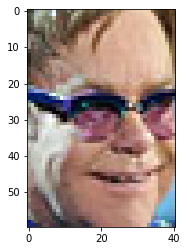

In [ ]:
#load train dataset
trainX,trainY = load_dataset('/content/drive/MyDrive/Emotion Detection/5-celebrity-faces-dataset/train/')
print(trainX.shape,trainY.shape)
#load train dataset
testX, testY = load_dataset('/content/drive/MyDrive/Emotion Detection/5-celebrity-faces-dataset/val/')
# save arrays to one file in compressed format
savez_compressed('/content/drive/MyDrive/Emotion Detection/5-celebrity-faces-dataset.npz',trainX, trainY, testX, testY)

In [ ]:

# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
import numpy as np
from numpy import savez_compressed
from keras.models import load_model

# load the face dataset
data = load('/content/drive/MyDrive/Emotion Detection/5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [ ]:
#below function will calculate a face embedding for each face in the dataset using facenet
#a face image dataset will be converted in to a matrix with size of 'number of faces (n) x 128 element'

def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std() 
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = np.expand_dims(face_pixels,axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]


In [ ]:
# load the face dataset
data = load('/content/drive/MyDrive/Emotion Detection/5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

# load the facenet model
model = load_model('/content/drive/MyDrive/Emotion Detection/facenet_keras.h5')
print('Loaded Model')

# convert each face in the train set to an embedding
newTrainX = list()

for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
 
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

# save arrays to one file in compressed format
savez_compressed('/content/drive/MyDrive/Emotion Detection/5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
Loaded Model
(93, 128)
(25, 128)


In [ ]:

# load face embedding dataset
data = load('/content/drive/MyDrive/Emotion Detection/5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0])) # shape[0] = row, shape[1]=column

Dataset: train=93, test=25


In [ ]:
#example of fitting a Linear SVM on the face embeddings for the 5 Celebrity Faces Dataset
# develop a classifier for the 5 Celebrity Faces Dataset

from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load dataset
data = load('/content/drive/MyDrive/Emotion Detection/5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0])) # shape[0] = row, shape[1]=column

# normalize input vectors using  Normalizer class in scikit-learn
#(normalization is required since vectors are compared to each other using a distance metric)
in_encoder = Normalizer(norm='l2') #[L2 norm is set] 
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# labelencode targets [converting string variables to integers]
# labelencode function - Encode target labels with value between 0 and [no of classes]-1.
# its more like normalization of the output
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

# fit model
#It is common to use a Linear Support Vector Machine (SVM) when working with normalized face embedding inputs.
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy) #fitting the training data

# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)

# score check between X and Y values of same dataset
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=93, test=25
Accuracy: train=100.000, test=100.000


Predicted: madonna (83.469)
Expected: madonna


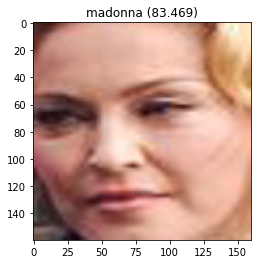

[[[[  3   3   3]
   [  1   1   1]
   [  0   0   0]
   ...
   [  2   2   2]
   [  4   4   3]
   [  4   4   2]]

  [[  1   1   1]
   [  2   2   2]
   [  2   2   2]
   ...
   [  2   2   3]
   [  2   2   2]
   [  2   2   2]]

  [[  1   1   1]
   [  2   2   2]
   [  2   2   2]
   ...
   [  2   2   3]
   [  2   2   2]
   [  2   2   2]]

  ...

  [[ 68  59  50]
   [ 70  61  52]
   [ 72  62  55]
   ...
   [ 12   0   0]
   [ 10   3   0]
   [ 14  11   1]]

  [[ 75  66  57]
   [ 74  65  56]
   [ 73  64  55]
   ...
   [  7   0   0]
   [  8   3   1]
   [ 11   8   3]]

  [[ 77  69  58]
   [ 77  68  59]
   [ 77  68  59]
   ...
   [  3   0   0]
   [  4   2   1]
   [  4   4   2]]]


 [[[ 20  21  18]
   [ 19  19  17]
   [ 17  15  15]
   ...
   [ 18  11   8]
   [ 19  12   9]
   [ 19  13   9]]

  [[ 20  21  19]
   [ 19  19  17]
   [ 17  15  15]
   ...
   [ 20  11   8]
   [ 21  12   9]
   [ 21  13   9]]

  [[ 22  22  21]
   [ 20  20  19]
   [ 16  15  15]
   ...
   [ 22   8   6]
   [ 24  11   8]
   [ 25  13

In [ ]:
# Now we will test the model on random photo samples in test dataset

from random import choice
from numpy import load

data = load('/content/drive/MyDrive/Emotion Detection/5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']

# generating a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]

#getting the relevant face embedding
random_face_emb = testX[selection]

#finding class number - testy is the label number
random_face_class = testy[selection] 

#finding the class name (identification of customer)
random_face_name = out_encoder.inverse_transform([random_face_class])


# prediction for the face identity and matching probability
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)


# get exact values for class and probability
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100

#finding the 'class name' of the predicted output
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()
print(testX_faces)


In [ ]:
#add a coding to test a random face with the model prediction

In [ ]:
#MOOD PREDICTOR

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
import os

num_classes=5
img_rows,img_cols=48,48
batch_size=128

train_data_dir='/content/drive/MyDrive/Emotion Detection/fer2013/train'
validation_data_dir='/content/drive/MyDrive/Emotion Detection/fer2013/validation'
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:

train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        color_mode='grayscale',
                        target_size=(img_rows,img_cols),
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
                                validation_data_dir,
                                color_mode='grayscale',
                                target_size=(img_rows,img_cols),
                                batch_size=batch_size,
                                class_mode='categorical',
                                shuffle=True)

Found 28353 images belonging to 6 classes.
Found 3534 images belonging to 6 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1592 (Conv2D)         (None, 48, 48, 32)        320       
_________________________________________________________________
activation_11 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1593 (Conv2D)         (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_796 (MaxPoolin (None, 24, 24, 32)       

In [ ]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Emotion Detection/EmotionDetectionModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop,checkpoint,reduce_lr]

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

epochs=25



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#TESTING
from keras.models import load_model
import pickle
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)   #warnings are irritating, sorry :P
class_labels=['Angry','Happy','Neutral','Sad','Surprise']

emotdet=load_model('/content/drive/MyDrive/Emotion Detection/EmotionDetectionModel.h5')

In [ ]:
!pip install curtsies

     |████████████████████████████████| 53 kB 1.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 54 kB 2.1 MB/s 
  Created wheel for curtsies: filename=curtsies-0.3.10-py3-none-any.whl size=35214 sha256=922dca2e93e48b762cceeae2a9dd16468a4a5fa52630c24882423cb970bf5e12
  Stored in directory: /root/.cache/pip/wheels/0a/68/71/bdac55722d0d1a909e2ea519f4f908e07759a607c7b15899da
Successfully built curtsies


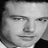

Neutral
##################################################################################


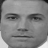

Neutral
##################################################################################


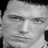

Neutral
##################################################################################


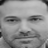

Neutral
##################################################################################


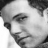

Neutral
##################################################################################


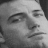

Neutral
##################################################################################


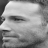

Sad
##################################################################################


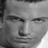

Sad
##################################################################################


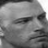

Sad
##################################################################################


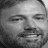

Happy
##################################################################################


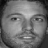

Neutral
##################################################################################


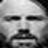

Sad
##################################################################################


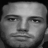

Neutral
##################################################################################


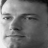

Neutral
##################################################################################


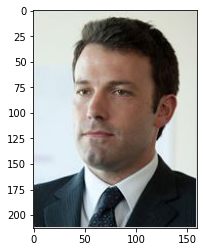

In [ ]:
from google.colab.patches import cv2_imshow
from curtsies.fmtfuncs import red, green, yellow, blue, cyan
import cv2
folder = '/content/drive/MyDrive/Emotion Detection/5-celebrity-faces-dataset/train/ben_afflek/'
i = 1

for filename in listdir(folder):
  path = folder + filename
  face = extract_face(path)
  face=cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
  face=cv2.resize(face, (48,48), interpolation = cv2.INTER_AREA)
  cv2_imshow(face)
  face=face.astype('float')/255.0
  face=img_to_array(face)
  face=np.expand_dims(face,axis=0)
  preds=emotdet.predict(face)
  plt.imshow(Image.open(path))
  pred=preds[0]
  print(cyan(class_labels[pred.argmax()]))
  print('##################################################################################')